# HW

1. Take 10 pictures of objects within the classifications of CIFAR-10 and change the image such that the format is the same (32x32 pixel resolution). Use your trained CNN model to classify the images. 
2. Train two more modified versions of the CNN model to improve the results of the first model. 

In [1]:
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, BatchNormalization
from keras.models import Sequential, load_model
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn import tree, datasets
from scipy.io import arff
from os.path import join
from timeit import default_timer as timer
from numba import cuda
from GPUtil import showUtilization as gpu_usage
import keras.datasets.cifar10 as cifar10
import tensorflow as tf
import numba
import torch
import datetime
import time
import os
import math
import json
import inspect
import concurrent.futures as cf  # doesn't work with sklearn
import pandas as pd
import numpy as np
import copy
import statistics as stt
import seaborn as sns
import pickle
import sys
sns.set_theme()
%matplotlib inline
tf.compat.v1.Session(
    config=tf.compat.v1.ConfigProto(log_device_placement=True))

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)


C:\Users\dachu\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [2]:
# params
model_root_path = os.path.join(os.getcwd().rstrip('src'), 'data', 'ml_w14_hw')


In [8]:
class CNN():
    def __init__(self, X_train, y_train, X_test, y_test):
        # data variables
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        # stats variables
        self.stats_dict = {
            'model_name': None,
            'model_file_path': None,
            'epochs': None,
            'batch_size': None,
            'building_time': None,
            'training_time': None,
            'testing_time': None,
            'loss': None,
            'accuracy': None,
            'evaluating_proba_time': None,
            }
        # labels
        self.label = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat",
                 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
        current_time = str(time.strftime("%Y/%m/%d %H:%M:%S", time.localtime()))
        self.stats_dict['time'] = current_time
        current_time = current_time.replace('/', '').replace(' ', '_').replace(':', '')
        self.current_time = current_time

    def build_model1(self):
        start = timer()
        activation1 = 'relu'
        channel1 = 100
        channel2 = 200
        channel3 = 400
        model = Sequential()
        model.add(Conv2D(channel1, (9, 9),
                         input_shape=X_train.shape[1:], activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(channel2, (5, 5), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(channel3, (3, 3), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(channel3, activation=activation1))
        model.add(Dropout(0.5))
        model.add(Dense(160, activation=activation1))
        model.add(Dense(40, activation=activation1))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam', metrics=['accuracy'])
        self.model = model
        self.stats_dict['building_time'] = timer() - start

    def build_model2(self):
        # testing conv layer depth
        # https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
        # it doesn't looks like 4th or more conv layers are possible (error: ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_4/convolution' (op: 'Conv2D') with input shapes: [?,1,1,256], [3,3,256,256].)
        start = timer()
        activation1 = 'relu'
        model = Sequential()
        model.add(Conv2D(32, (3, 3),
                         input_shape=X_train.shape[1:], activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(128, (3, 3), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(Conv2D(256, (3, 3), activation=activation1))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation=activation1))
        model.add(Dropout(0.5))
        model.add(Dense(160, activation=activation1))
        model.add(Dense(40, activation=activation1))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam', metrics=['accuracy'])
        self.model = model
        self.stats_dict['building_time'] = timer() - start

    def build_model3(self):
        # testing dense layer depth
        start = timer()
        activation1 = 'relu'
        model = Sequential()
        model.add(Conv2D(32, (3, 3),
                         input_shape=X_train.shape[1:], activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(128, (3, 3), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation=activation1))
        model.add(Dropout(0.5))
        model.add(Dense(256, activation=activation1))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation=activation1))
        model.add(Dense(64, activation=activation1))
        model.add(Dense(32, activation=activation1))
        model.add(Dense(16, activation=activation1))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam', metrics=['accuracy'])
        self.model = model
        self.stats_dict['building_time'] = timer() - start

    def build_model4(self):
        # testing even deeper dense layer
        start = timer()
        activation1 = 'relu'
        model = Sequential()
        model.add(Conv2D(32, (3, 3),
                        input_shape=X_train.shape[1:], activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(128, (3, 3), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation=activation1))
        model.add(Dropout(0.5))
        model.add(Dense(256, activation=activation1))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation=activation1))
        model.add(Dropout(0.5))
        model.add(Dense(1024, activation=activation1))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation=activation1))
        model.add(Dense(256, activation=activation1))
        model.add(Dense(128, activation=activation1))
        model.add(Dense(64, activation=activation1))
        model.add(Dense(32, activation=activation1))
        model.add(Dense(16, activation=activation1))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])
        self.model = model
        self.stats_dict['building_time'] = timer() - start

    def build_model5(self):
        # testing conv layer features
        # https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
        # it doesn't looks like 4th or more conv layers are possible (error: ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_4/convolution' (op: 'Conv2D') with input shapes: [?,1,1,256], [3,3,256,256].)
        start = timer()
        activation1 = 'relu'
        model = Sequential()
        model.add(Conv2D(32, (5, 5),
                         input_shape=X_train.shape[1:], activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(128, (3, 3), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(512, (3, 3), activation=activation1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(512, activation=activation1))
        model.add(Dropout(0.5))
        model.add(Dense(160, activation=activation1))
        model.add(Dense(40, activation=activation1))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam', metrics=['accuracy'])
        self.model = model
        self.stats_dict['building_time'] = timer() - start

    def build_model6(self):
        # testing deep conv layer
        start = timer()
        img_width = X_train.shape[1:][0]
        filter_size = 3
        layer_depth = img_width / (filter_size - 1)
        model = Sequential()
        model.add(Conv2D(32, (3, 3),
                             input_shape=X_train.shape[1:], activation='relu'))
        for i in range(int(layer_depth)-2):
            model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(160, activation='relu'))
        model.add(Dense(40, activation='relu'))
        model.add(Dense(10, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam', metrics=['accuracy'])
        self.model = model
        self.stats_dict['building_time'] = timer() - start

    def train_model(self, epochs=5, batch_size=500, verbose=1):
        self.stats_dict['epochs'] = epochs
        self.stats_dict['batch_size'] = batch_size
        start = timer()
        self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        self.stats_dict['training_time'] = timer() - start
        self.model.summary()

    def store_model(self, model_name, path=''):
        path = os.path.join(path, f'{model_name}_{self.current_time}.h5')
        print(path)
        self.model.save(path)
        self.stats_dict['model_name'] = model_name
        self.stats_dict['model_file_path'] = path

    def store_meta_data(self, model_name, path=''):
        # check empty values
        values = list(self.stats_dict.values())
        if None in values:
            arr = []
            for element in self.stats_dict:
                if self.stats_dict[element] == None:
                    arr.append(element)
            ans = input(
                f'Not all stats are recorded...\nThese stats are not recorded: {arr}\nDo you still want to export? (y/[n]): ')
            if ans != 'y':
                return
        
        # read meta data, append, and write
        path = os.path.join(path, 'model_meta_data.csv')
        if os.path.exists(path):
            meta_data = pd.read_csv(path, encoding='utf-8', index_col=0)
            meta_data = pd.concat([meta_data, pd.DataFrame(self.stats_dict, index=[0])])
            meta_data.reset_index(drop=True, inplace=True)
        else:
            meta_data = pd.DataFrame(self.stats_dict, index=[0])
        meta_data.to_csv(path, encoding='utf-8')
        print('Meta data exported to', path)

    def load_model(self, path):
        self.model = load_model(path)
        self.model_name = os.path.basename(path).split('.')[0]

    def evaluate(self):
        # record loss and accuracy
        start = timer()
        result = self.model.evaluate(X_test, y_test)
        self.stats_dict['loss'] = result[0]
        self.stats_dict['accuracy'] = result[1]
        self.stats_dict['testing_time'] = timer() - start

    def evaluate_proba(self, img_row_num=2, img_col_num=5, display_bar_num=3, random=False, start_img_num=0, save=False, path='', show=True):
        # top 1 accuracy
        '''
        display images and their predicted probabilities
        -----------------------------------------------------------------------
        start_img_num: start image number (necessary if random=False)
        save_img_path: path to save images
        img_row_num: number of rows of images
        img_col_num: number of columns of images
        display_bar_num: number of bars to display (probability of each class)
        random: if True, select images randomly
        save: if True, save images
        show: if True, show images
        -----------------------------------------------------------------------
        src: https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot
        '''
        start = timer()
        model = self.model
        X_test = self.X_test
        y_test = self.y_test
        label = self.label
        # load test data (images)
        image_count = img_row_num * img_col_num
        test_image_count = X_test.shape[0]
        if random:
            selected_image_indexes = np.random.choice(a=test_image_count, size=image_count, replace=False)
            selected_image = X_test[selected_image_indexes]
        else:
            selected_image_indexes = np.arange(
                start=start_img_num, stop=start_img_num+image_count)
            selected_image = X_test[selected_image_indexes]
        # predict
        probabilities = model.predict(selected_image)
        # calculate prediction accuracy
        correct_count = 0
        for i in range(image_count):
            prediction = np.argmax(probabilities[i])
            answer = np.argmax(y_test[selected_image_indexes[i]])
            if prediction == answer:
                correct_count += 1
        accuracy = correct_count / image_count * 100
        # plot
        fig = plt.figure(figsize=(img_col_num*2, img_row_num*2), dpi=300)
        plt.title(
            f'Top {display_bar_num} Accuracy of {image_count} Images ({img_col_num} x {img_row_num})\nAccuracy of this batch: {accuracy:.2f}%', pad=30)
        plt.axis('off')
        outer = gridspec.GridSpec(img_row_num, img_col_num, wspace=0.1, hspace=0.1)
        for i in range(image_count):
            prediction = label[np.argmax(probabilities[i])]
            answer = label[np.argmax(y_test[selected_image_indexes[i]])]
            x = i//img_col_num
            y = i%img_col_num
            inner = gridspec.GridSpecFromSubplotSpec(
                2, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
            # plot image
            ax = plt.Subplot(fig, inner[0])
            ax.set_title(f'{prediction} ({answer})', fontsize=8)
            ax.imshow(selected_image[i])
            ax.axis('off')
            fig.add_subplot(ax)
            # get top x probabilities
            temp_probabilities = (copy.copy(probabilities[i])).tolist()
            temp_probabilities.sort(reverse=True)
            temp_probabilities = temp_probabilities[:display_bar_num]
            temp_label = []
            for j in temp_probabilities:
                prob_list = probabilities[i].tolist()
                index = prob_list.index(j)
                temp_label.append(label[index])
            # plot bar
            ax = plt.Subplot(fig, inner[1])
            ax.barh(np.arange(display_bar_num),
                    temp_probabilities, align='center', alpha=0.5)
            for element in temp_label:
                text = f'{element} ({temp_probabilities[temp_label.index(element)]*100:.2f}%)'
                ax.text(0.01, temp_label.index(element), text, fontsize=6, va='center')
            ax.invert_yaxis()
            ax.axis('off')
            fig.add_subplot(ax)
        if save:
            path = os.path.join(
                path, '{}_eval_top{}_{}x{}_{}-{}.png'.format(self.model_name, display_bar_num, img_col_num, img_row_num, start_img_num, start_img_num+image_count))
            plt.savefig(path)
        if show:
            plt.show()
        plt.close()
        print('Image exported to', path)
        self.stats_dict['evaluating_proba_time'] = timer() - start

    def clear_mem(self):
        # https://www.kaggle.com/getting-started/140636
        torch.cuda.empty_cache()
        cuda.select_device(0)
        cuda.close()
        cuda.select_device(0)
        print('Cleared GPU memory')

    def plot_history(self, model_name, path):
        history = self.history
        plt.figure(figsize=(20, 20), dpi=300)
        # plot loss
        plt.subplot(211)
        plt.title(f'{model_name}_{self.current_time} - Train Loss')
        plt.plot(history.history['loss'], label='train_loss')
        plt.xlabel('Epoch')
        # plt.legend(loc='upper right')
        # plot accuracy
        plt.subplot(212)
        plt.title(f'{model_name}_{self.current_time} - Train Accuracy')
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.xlabel('Epoch')
        # plt.legend(loc='lower right')
        # save
        path = os.path.join(
            path, f'{model_name}_{self.current_time}_train_hist.png')
        plt.savefig(path)
        plt.close()




## Model Building

In [77]:
# model1
cnn = CNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
cnn.build_model1()
cnn.train_model(epochs=100, batch_size=500, verbose=1)
cnn.plot_history(model_name='model1', path=model_root_path)
cnn.store_model(model_name='model1', path=model_root_path)
cnn.evaluate()
cnn.store_meta_data(model_name='model1', path=model_root_path)
# cnn.clear_mem()


Epoch 1/100
100/100 [==============================] - 6s 53ms/step - loss: 2.9141 - accuracy: 0.1194
Epoch 2/100
100/100 [==============================] - 5s 52ms/step - loss: 2.1488 - accuracy: 0.1936
Epoch 3/100
100/100 [==============================] - 5s 53ms/step - loss: 1.8653 - accuracy: 0.3103
Epoch 4/100
100/100 [==============================] - 5s 53ms/step - loss: 1.7281 - accuracy: 0.3634
Epoch 5/100
100/100 [==============================] - 5s 54ms/step - loss: 1.6394 - accuracy: 0.4044
Epoch 6/100
100/100 [==============================] - 5s 53ms/step - loss: 1.5518 - accuracy: 0.4418
Epoch 7/100
100/100 [==============================] - 6s 56ms/step - loss: 1.4821 - accuracy: 0.4682
Epoch 8/100
100/100 [==============================] - 6s 56ms/step - loss: 1.4300 - accuracy: 0.4906
Epoch 9/100
100/100 [==============================] - 5s 55ms/step - loss: 1.3871 - accuracy: 0.5020
Epoch 10/100
100/100 [==============================] - 5s 53ms/step - loss: 1.324

In [63]:
# model2
cnn = CNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
cnn.build_model2()
cnn.train_model(epochs=100, batch_size=500, verbose=1)
cnn.plot_history(model_name='model2', path=model_root_path)
cnn.store_model(model_name='model2', path=model_root_path)
cnn.evaluate()
cnn.store_meta_data(model_name='model2', path=model_root_path)
# cnn.clear_mem()


Epoch 1/100
100/100 [==============================] - 3s 19ms/step - loss: 2.8197 - accuracy: 0.1740
Epoch 2/100
100/100 [==============================] - 2s 18ms/step - loss: 1.8401 - accuracy: 0.3060
Epoch 3/100
100/100 [==============================] - 2s 17ms/step - loss: 1.6284 - accuracy: 0.3971
Epoch 4/100
100/100 [==============================] - 2s 22ms/step - loss: 1.4881 - accuracy: 0.4595
Epoch 5/100
100/100 [==============================] - 2s 18ms/step - loss: 1.3945 - accuracy: 0.4942
Epoch 6/100
100/100 [==============================] - 2s 18ms/step - loss: 1.3023 - accuracy: 0.5331
Epoch 7/100
100/100 [==============================] - 2s 18ms/step - loss: 1.2480 - accuracy: 0.5576
Epoch 8/100
100/100 [==============================] - 2s 20ms/step - loss: 1.1916 - accuracy: 0.5782
Epoch 9/100
100/100 [==============================] - 2s 22ms/step - loss: 1.1256 - accuracy: 0.6025
Epoch 10/100
100/100 [==============================] - 2s 21ms/step - loss: 1.082

In [66]:
# model3
cnn = CNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
cnn.build_model3()
cnn.train_model(epochs=100, batch_size=500, verbose=1)
cnn.plot_history(model_name='model3', path=model_root_path)
cnn.store_model(model_name='model3', path=model_root_path)
cnn.evaluate()
cnn.store_meta_data(model_name='model3', path=model_root_path)
# cnn.clear_mem()


Epoch 1/100
100/100 [==============================] - 3s 21ms/step - loss: 2.5136 - accuracy: 0.1065
Epoch 2/100
100/100 [==============================] - 2s 20ms/step - loss: 2.1587 - accuracy: 0.1809
Epoch 3/100
100/100 [==============================] - 2s 21ms/step - loss: 1.9291 - accuracy: 0.2534
Epoch 4/100
100/100 [==============================] - 2s 22ms/step - loss: 1.7573 - accuracy: 0.3211
Epoch 5/100
100/100 [==============================] - 2s 20ms/step - loss: 1.6501 - accuracy: 0.3738
Epoch 6/100
100/100 [==============================] - 2s 19ms/step - loss: 1.5417 - accuracy: 0.4200
Epoch 7/100
100/100 [==============================] - 2s 19ms/step - loss: 1.4476 - accuracy: 0.4555
Epoch 8/100
100/100 [==============================] - 2s 18ms/step - loss: 1.3568 - accuracy: 0.4971
Epoch 9/100
100/100 [==============================] - 2s 19ms/step - loss: 1.2911 - accuracy: 0.5256
Epoch 10/100
100/100 [==============================] - 2s 18ms/step - loss: 1.209

In [71]:
# model4
cnn = CNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
cnn.build_model4()
cnn.train_model(epochs=100, batch_size=500, verbose=1)
cnn.plot_history(model_name='model4', path=model_root_path)
cnn.store_model(model_name='model4', path=model_root_path)
cnn.evaluate()
cnn.store_meta_data(model_name='model4', path=model_root_path)
# cnn.clear_mem()


Epoch 1/100
100/100 [==============================] - 4s 22ms/step - loss: 2.3510 - accuracy: 0.1238
Epoch 2/100
100/100 [==============================] - 2s 21ms/step - loss: 2.1008 - accuracy: 0.1953
Epoch 3/100
100/100 [==============================] - 2s 21ms/step - loss: 1.9142 - accuracy: 0.2382
Epoch 4/100
100/100 [==============================] - 2s 21ms/step - loss: 1.7801 - accuracy: 0.2768
Epoch 5/100
100/100 [==============================] - 2s 21ms/step - loss: 1.6730 - accuracy: 0.3394
Epoch 6/100
100/100 [==============================] - 2s 21ms/step - loss: 1.5944 - accuracy: 0.3773
Epoch 7/100
100/100 [==============================] - 2s 22ms/step - loss: 1.5264 - accuracy: 0.4056
Epoch 8/100
100/100 [==============================] - 2s 20ms/step - loss: 1.4520 - accuracy: 0.4349
Epoch 9/100
100/100 [==============================] - 2s 22ms/step - loss: 1.4054 - accuracy: 0.4605
Epoch 10/100
100/100 [==============================] - 2s 21ms/step - loss: 1.376

In [76]:
# model5
cnn = CNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
cnn.build_model5()
cnn.train_model(epochs=100, batch_size=1000, verbose=1)
cnn.plot_history(model_name='model5', path=model_root_path)
cnn.store_model(model_name='model5', path=model_root_path)
cnn.evaluate()
cnn.store_meta_data(model_name='model5', path=model_root_path)
# cnn.clear_mem()


Epoch 1/100
50/50 [==============================] - 6s 65ms/step - loss: 4.0249 - accuracy: 0.1685
Epoch 2/100
50/50 [==============================] - 3s 68ms/step - loss: 1.7981 - accuracy: 0.3380
Epoch 3/100
50/50 [==============================] - 3s 68ms/step - loss: 1.5483 - accuracy: 0.4413
Epoch 4/100
50/50 [==============================] - 3s 66ms/step - loss: 1.4116 - accuracy: 0.4970
Epoch 5/100
50/50 [==============================] - 3s 66ms/step - loss: 1.3053 - accuracy: 0.5382
Epoch 6/100
50/50 [==============================] - 3s 66ms/step - loss: 1.2180 - accuracy: 0.5698
Epoch 7/100
50/50 [==============================] - 3s 66ms/step - loss: 1.1161 - accuracy: 0.6090
Epoch 8/100
50/50 [==============================] - 3s 65ms/step - loss: 1.0536 - accuracy: 0.6263
Epoch 9/100
50/50 [==============================] - 3s 66ms/step - loss: 0.9910 - accuracy: 0.6502
Epoch 10/100
50/50 [==============================] - 3s 66ms/step - loss: 0.9146 - accuracy: 0.6771

In [9]:
# model6
cnn = CNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
cnn.build_model6()
cnn.train_model(epochs=100, batch_size=1000, verbose=1)
cnn.plot_history(model_name='model5', path=model_root_path)
cnn.store_model(model_name='model5', path=model_root_path)
cnn.evaluate()
cnn.store_meta_data(model_name='model5', path=model_root_path)
# cnn.clear_mem()


Epoch 1/100
50/50 [==============================] - 16s 152ms/step - loss: 2.3019 - accuracy: 0.1041
Epoch 2/100
50/50 [==============================] - 8s 152ms/step - loss: 2.3054 - accuracy: 0.1055
Epoch 3/100
50/50 [==============================] - 8s 153ms/step - loss: 2.1334 - accuracy: 0.1613
Epoch 4/100
50/50 [==============================] - 8s 153ms/step - loss: 1.9549 - accuracy: 0.2290
Epoch 5/100
50/50 [==============================] - 8s 154ms/step - loss: 1.8254 - accuracy: 0.2965
Epoch 6/100
50/50 [==============================] - 8s 154ms/step - loss: 1.7374 - accuracy: 0.3387
Epoch 7/100
50/50 [==============================] - 8s 155ms/step - loss: 1.6678 - accuracy: 0.3742
Epoch 8/100
50/50 [==============================] - 8s 154ms/step - loss: 1.5800 - accuracy: 0.4097
Epoch 9/100
50/50 [==============================] - 8s 155ms/step - loss: 1.5045 - accuracy: 0.4397
Epoch 10/100
50/50 [==============================] - 8s 155ms/step - loss: 1.4257 - accur

NameError: name 'model_root_path' is not defined

## Model Evaluating

1/1 [==============================] - 1s 739ms/step


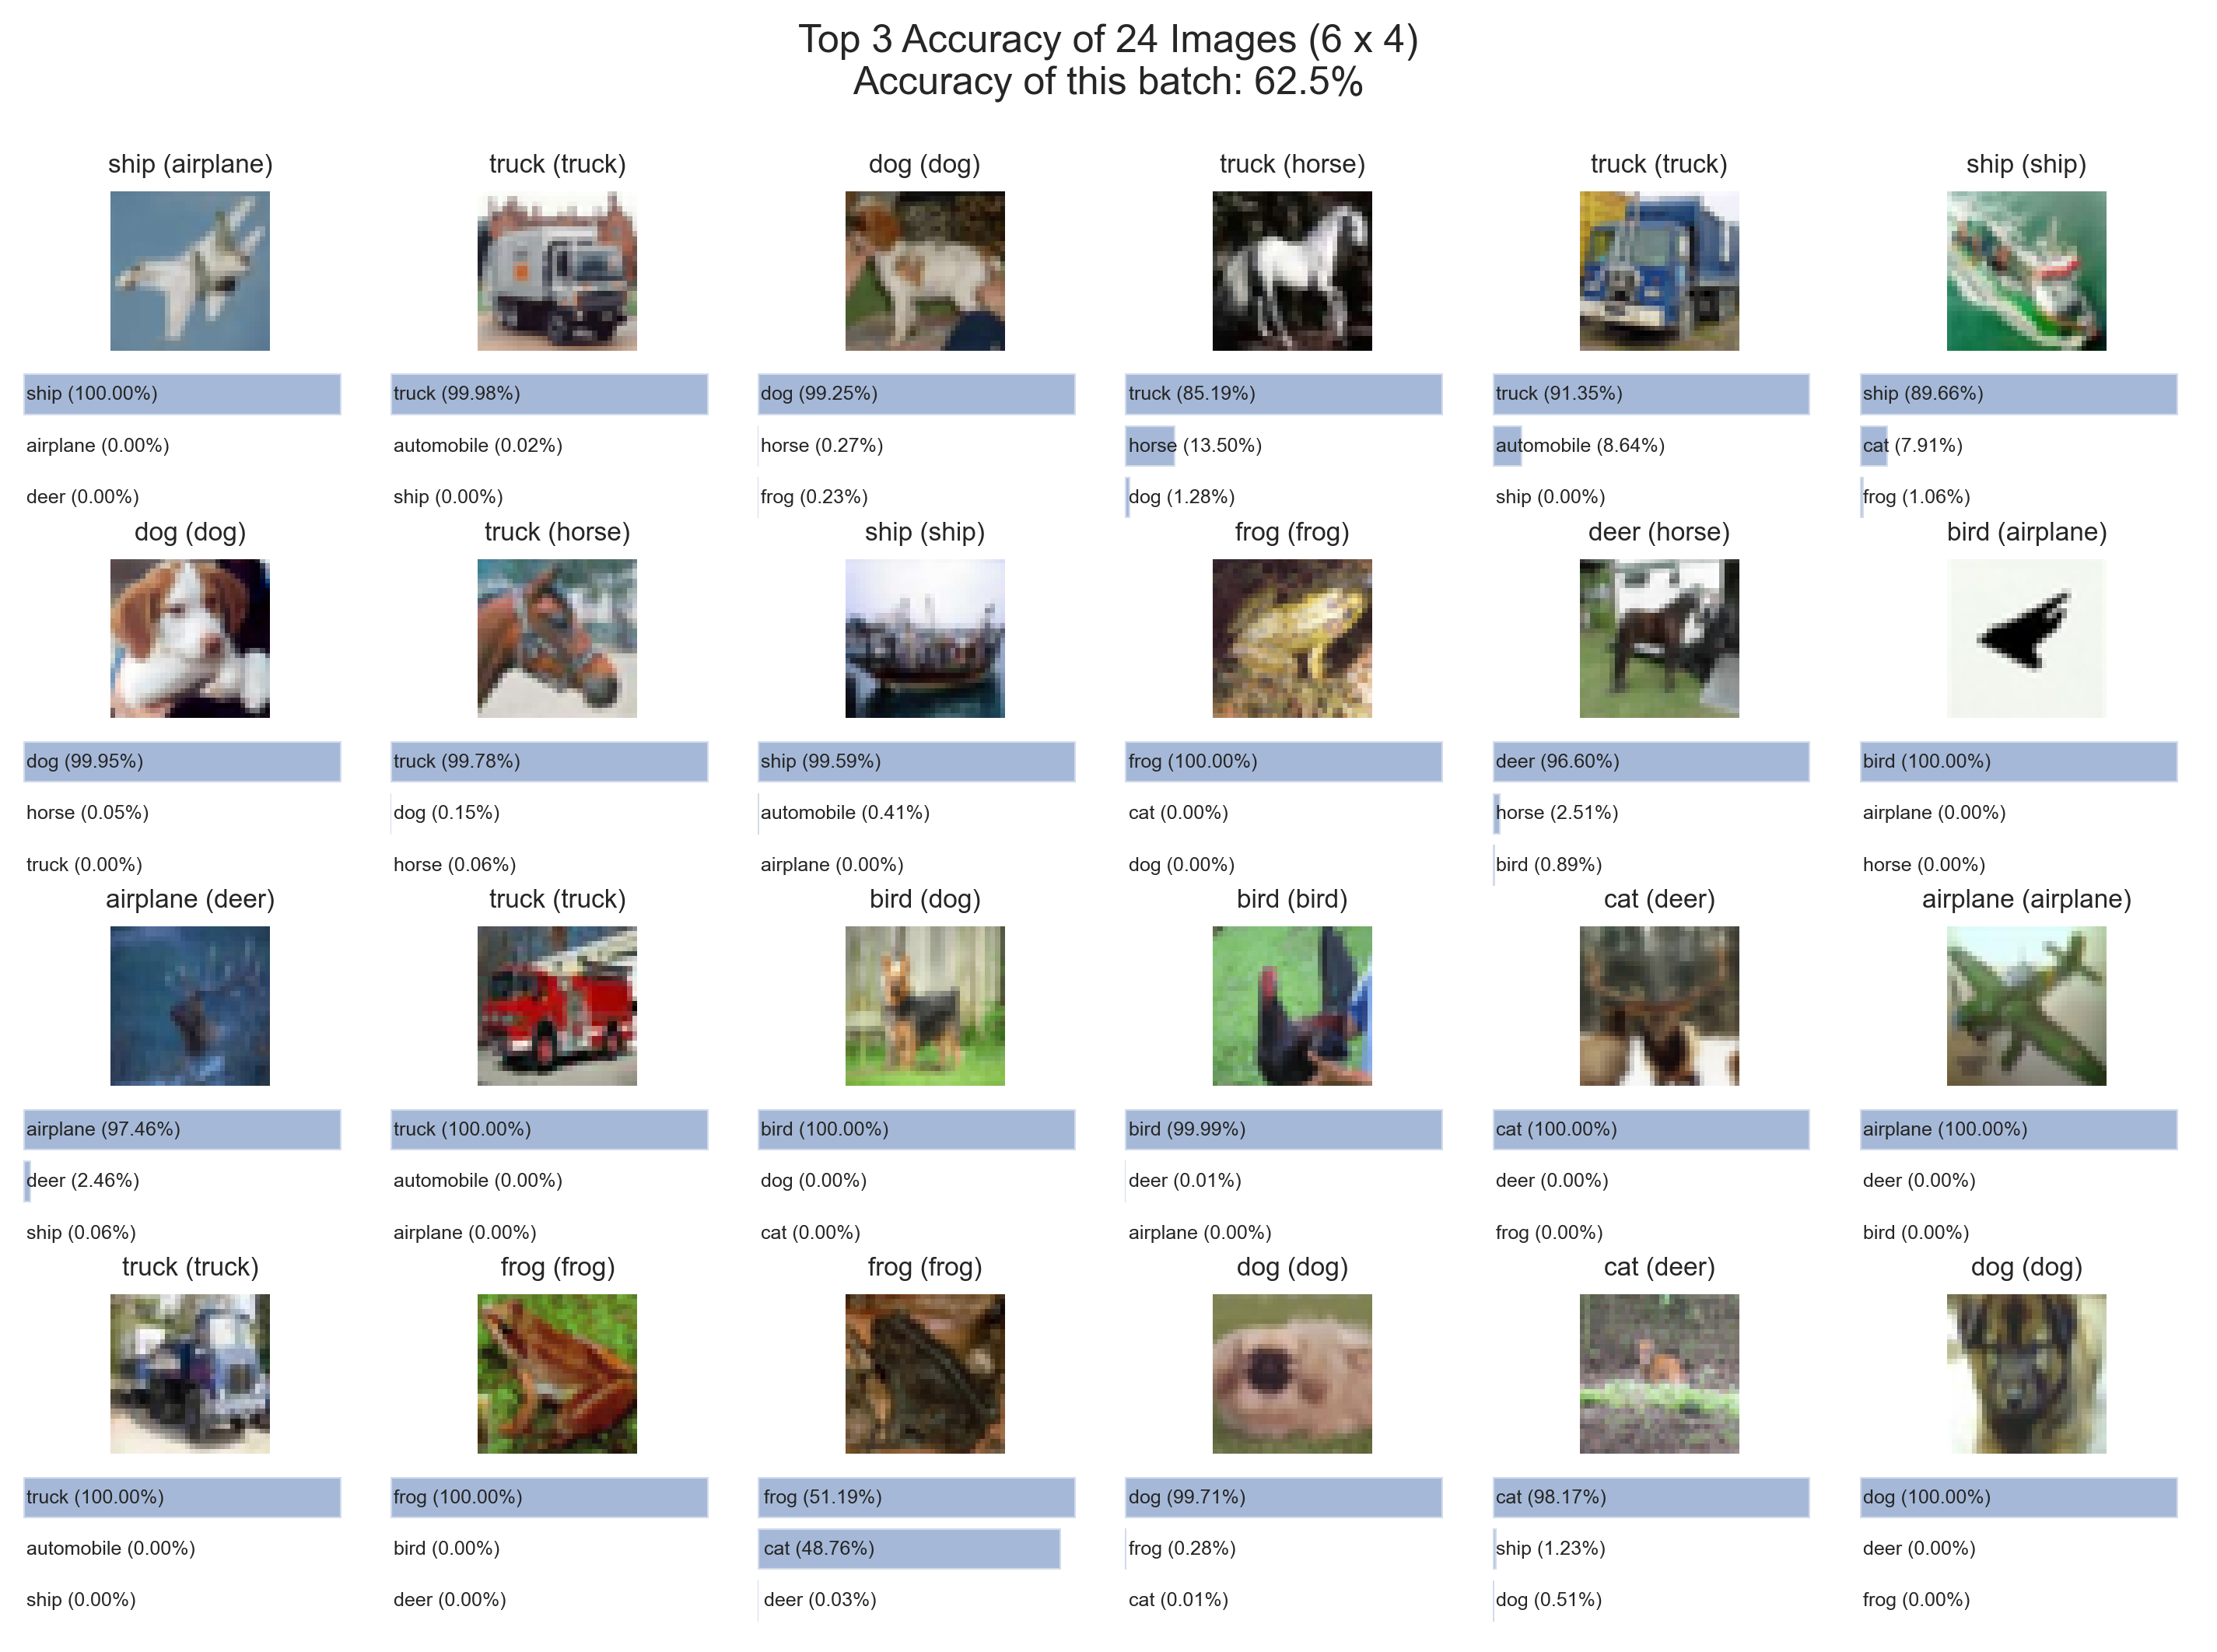

In [175]:
# evaluate_proba
cnn = CNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
cnn.load_model('D:/Note_Database/Subject/BD_ML Big Data and Machine Learning/BD_ML_Code/data/ml_w14_hw/model1_20221217_031354.h5')
cnn.evaluate_proba(img_row_num=4, img_col_num=6,
                   display_bar_num=3, random=False, start_img_num=10,
                   save=True, path=model_root_path,show=True)
